In [10]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score, mean_absolute_error

In [11]:
training_upto = 2018
forecast_upto = (2023-training_upto-1)*12 +3

## Prediction Whole of Barnet

In [12]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:\\Users\\20203697\\Downloads\\filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Burglary Rate'].sum()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
# monthly_grouped_df = monthly_grouped_df[(monthly_grouped_df['Year']>=2011) | ((monthly_grouped_df['Year'] == 2010) & (monthly_grouped_df['Month num']==12))]
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
print(monthly_grouped_df)
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Burglary Rate']
# monthly_grouped_df = monthly_grouped_df.set_index(pd.DatetimeIndex(monthly_grouped_df['Date']))

# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    #holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0]), ignore_index=True)
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

monthly_grouped_df


     year  month  Burglary Rate  day
0    2010     12            359    1
1    2011      1            463    1
2    2011      2            385    1
3    2011      3            403    1
4    2011      9            294    1
..    ...    ...            ...  ...
138  2022     11            231    1
139  2022     12            221    1
140  2023      1            237    1
141  2023      2            193    1
142  2023      3            223    1

[143 rows x 4 columns]


,year,month,Burglary Rate,day,ds,y
0,2010,12,359,1,2010-12-01,359
1,2011,1,463,1,2011-01-01,463
2,2011,2,385,1,2011-02-01,385
3,2011,3,403,1,2011-03-01,403
4,2011,9,294,1,2011-09-01,294
...,...,...,...,...,...,...
138,2022,11,231,1,2022-11-01,231
139,2022,12,221,1,2022-12-01,221
140,2023,1,237,1,2023-01-01,237
141,2023,2,193,1,2023-02-01,193


### Hyper-parameter tuning

In [13]:
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.05, 0.01, 0.15],
    'seasonality_prior_scale': [0.05, 0.01, 0.15],
    'holidays_prior_scale':[0.005,0.01,0.015],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

11:05:23 - cmdstanpy - INFO - Chain [1] start processing
11:05:23 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

### Model

11:10:26 - cmdstanpy - INFO - Chain [1] start processing
11:10:27 - cmdstanpy - INFO - Chain [1] done processing


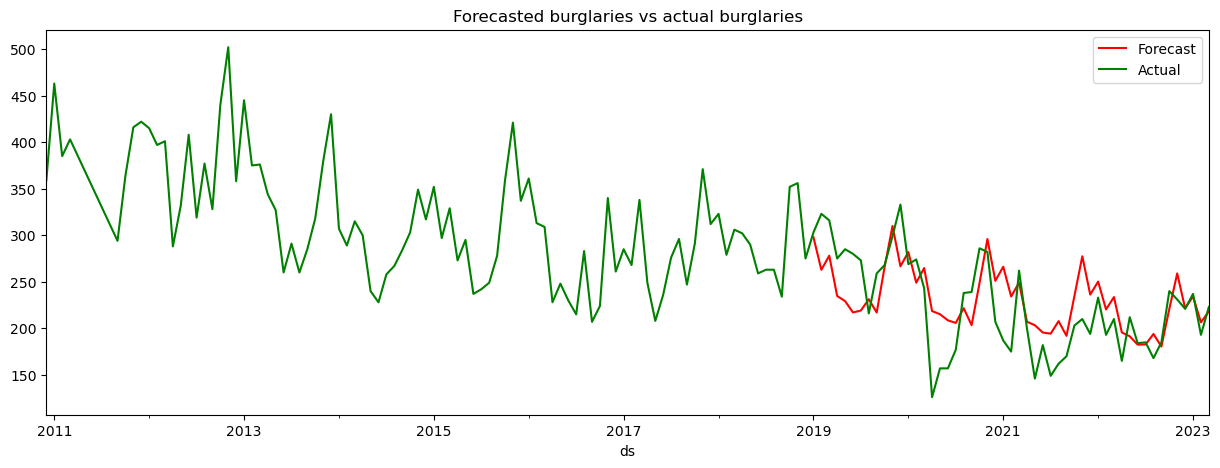

31.310501304154144


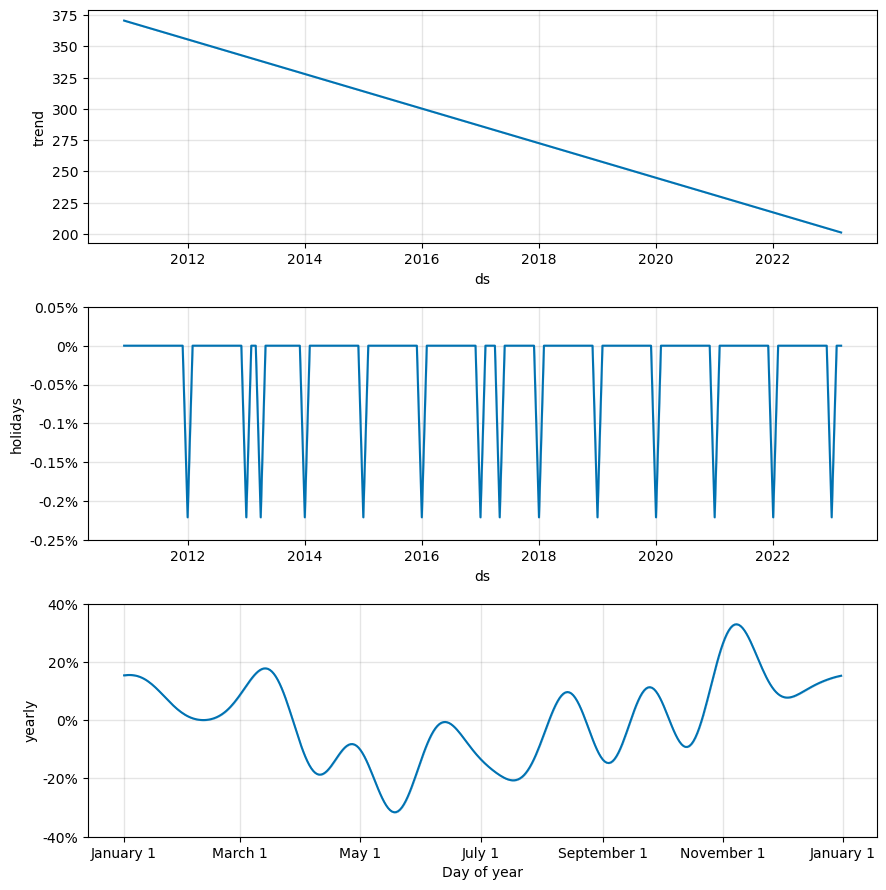

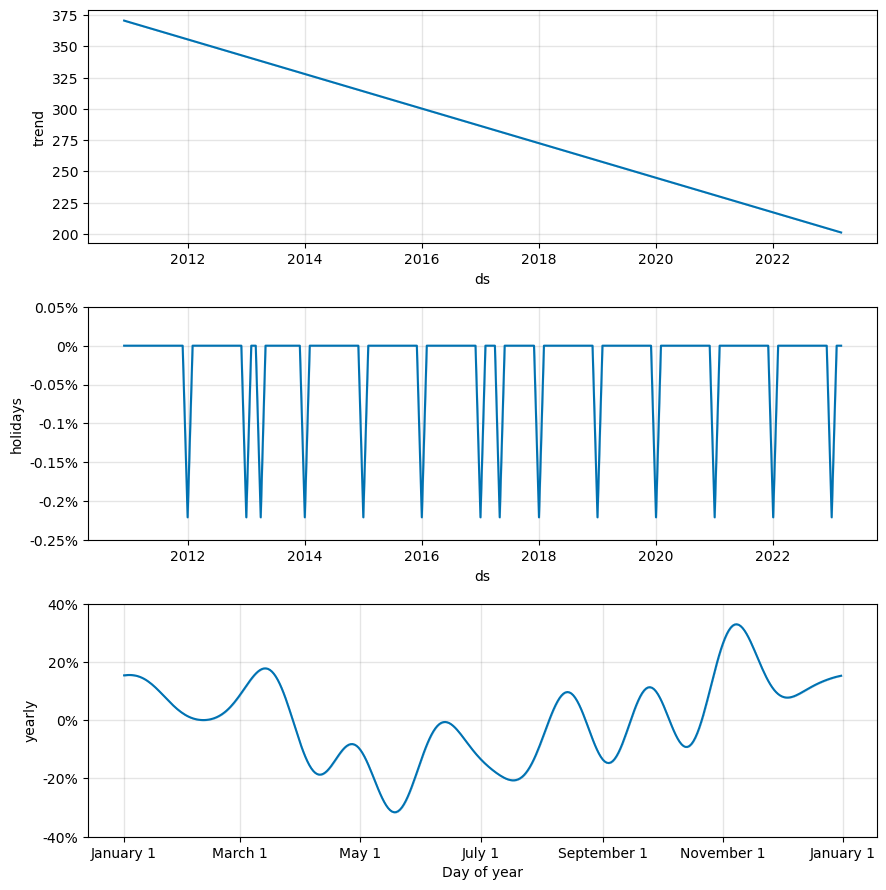

In [18]:
# Train the model with the best parameters and forecast

best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday).fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries')
plt.show()

print(mean_absolute_error(test_data['y'], forecast['yhat'][-forecast_upto:]))
r2_score(test_data['y'], forecast['yhat'][-forecast_upto:])

best_model.plot_components(forecast)

## Prediction per ward

In [15]:
# Create the dataframe
df_per_ward =  pd.read_csv('C:/Users/20203697/Downloads/filtered_df_utility_cols.csv')

# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['y'] = df_per_ward['Burglary Rate']
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

11:05:45 - cmdstanpy - INFO - Chain [1] start processing


0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:45 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Brunswick Park
-0.10701320038663331


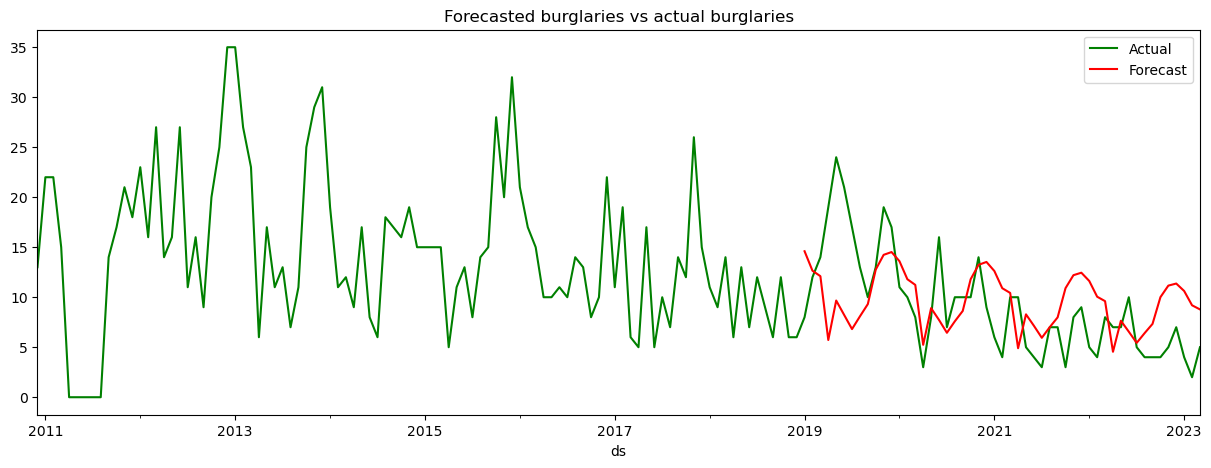

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:46 - cmdstanpy - INFO - Chain [1] start processing
11:05:47 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Burnt Oak
-0.06862192518546872


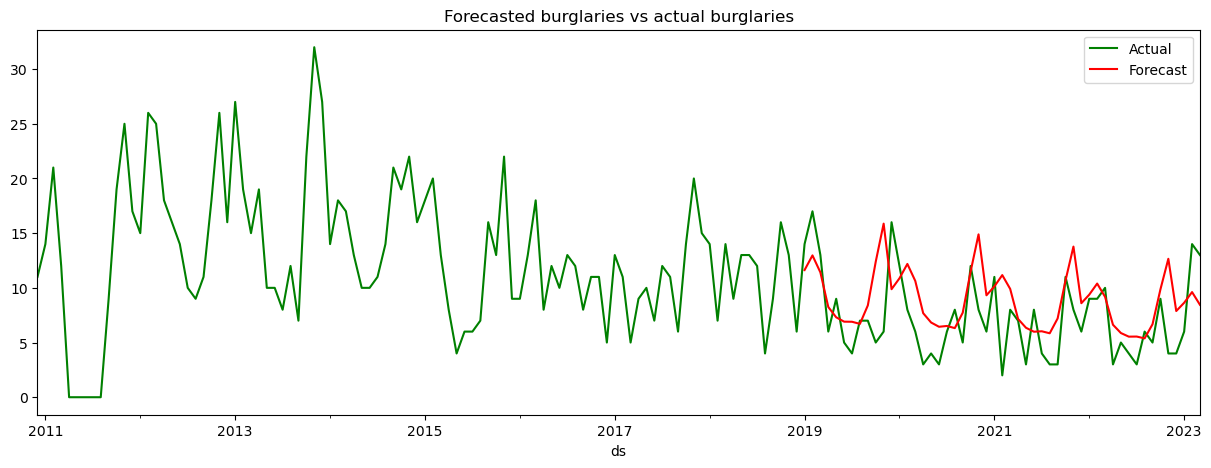

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:47 - cmdstanpy - INFO - Chain [1] start processing
11:05:48 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Childs Hill
-0.993078124125033


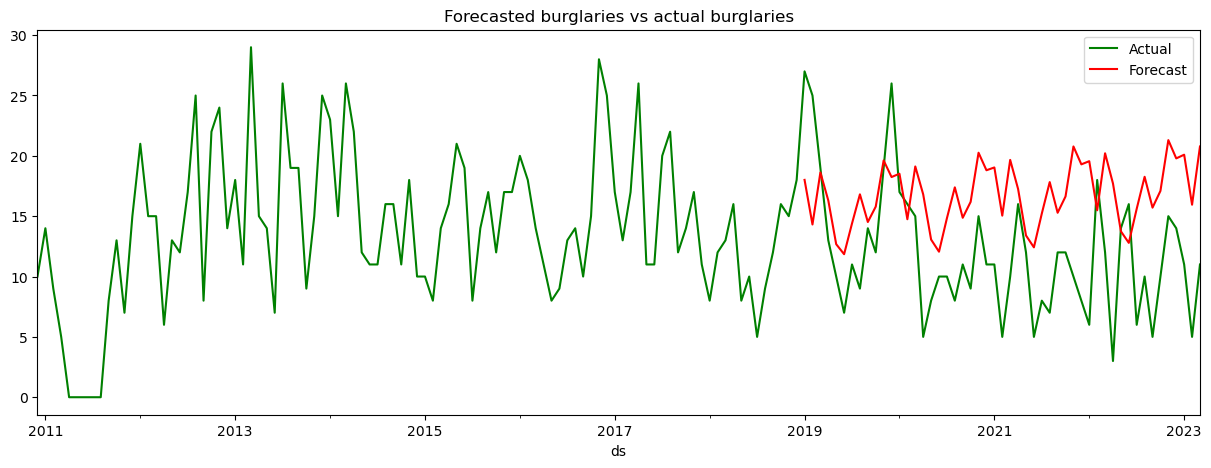

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:48 - cmdstanpy - INFO - Chain [1] start processing
11:05:48 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
East Barnet
-0.2055299298270239


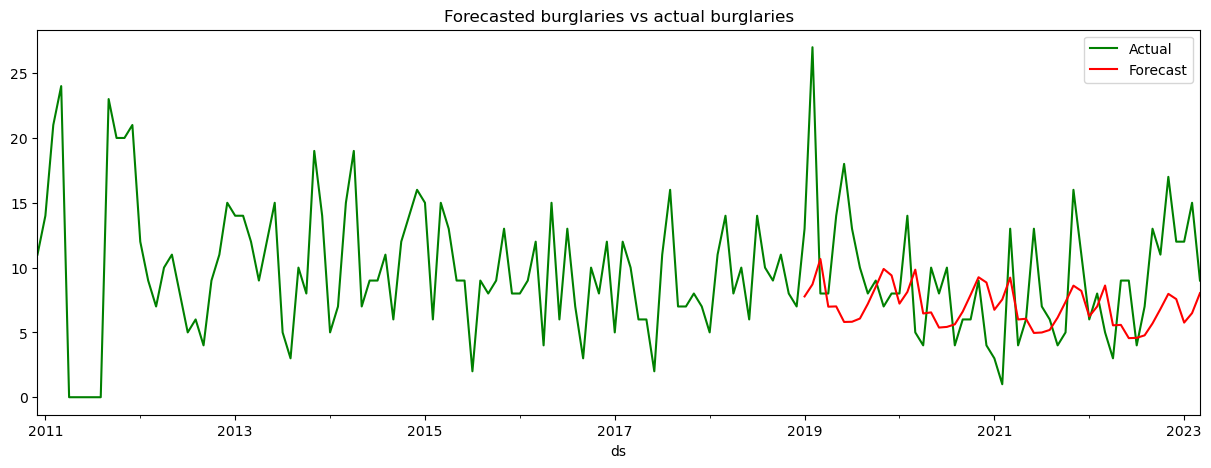

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:50 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
East Finchley
0.19715690043620304


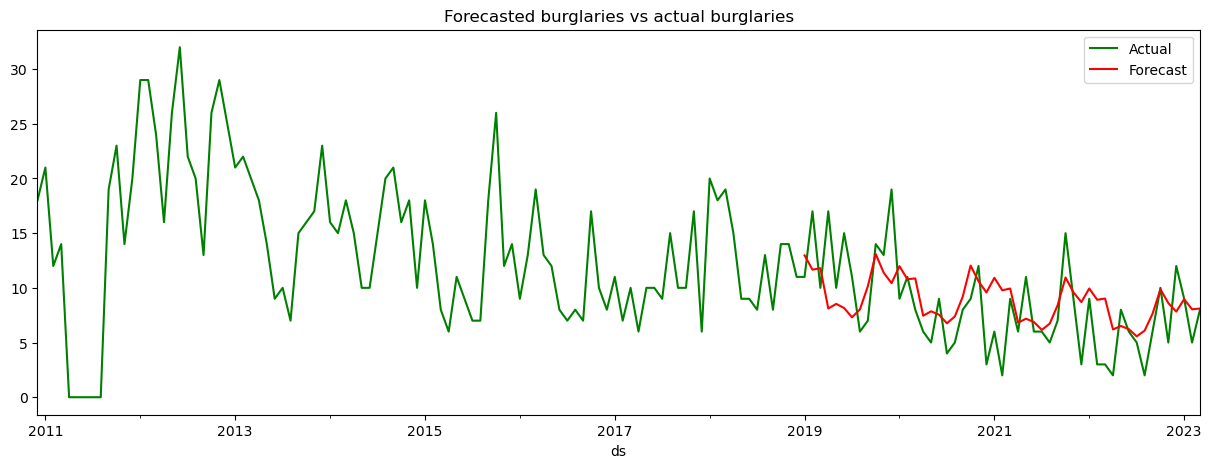

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:50 - cmdstanpy - INFO - Chain [1] start processing
11:05:51 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Edgware
-0.3260850968858804


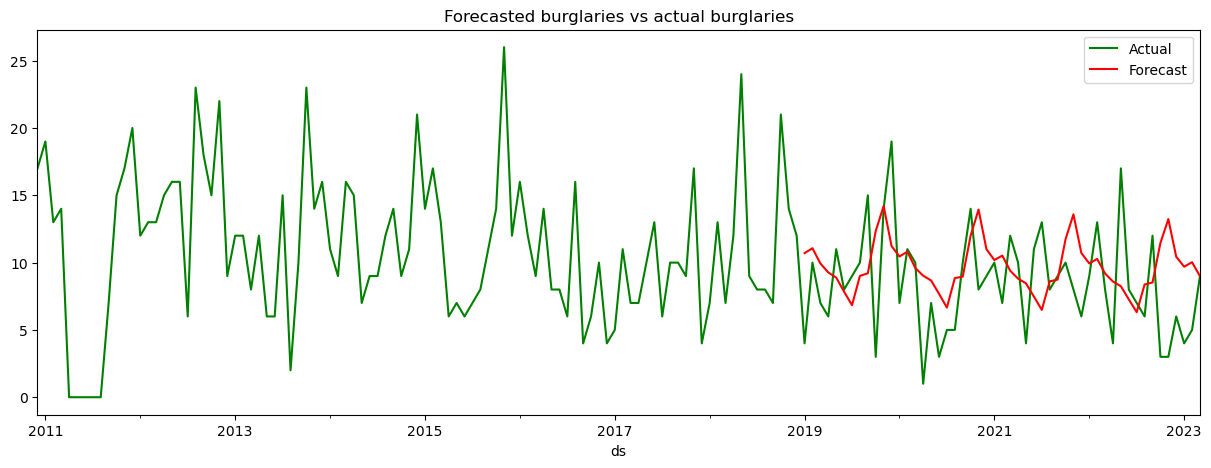

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:51 - cmdstanpy - INFO - Chain [1] start processing
11:05:52 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Finchley Church End
-0.4819105535712549


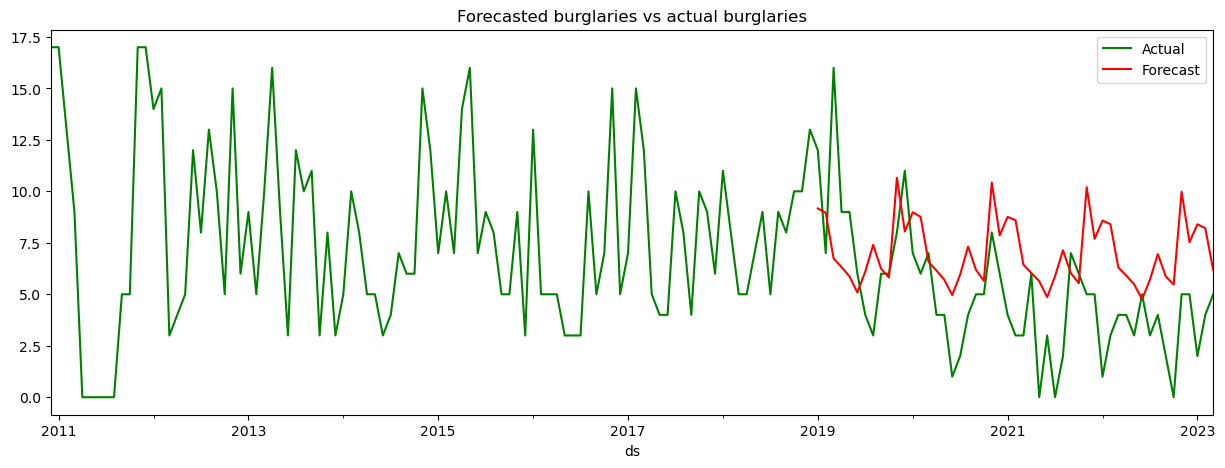

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:52 - cmdstanpy - INFO - Chain [1] start processing
11:05:53 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Garden Suburb
0.2843689083942391


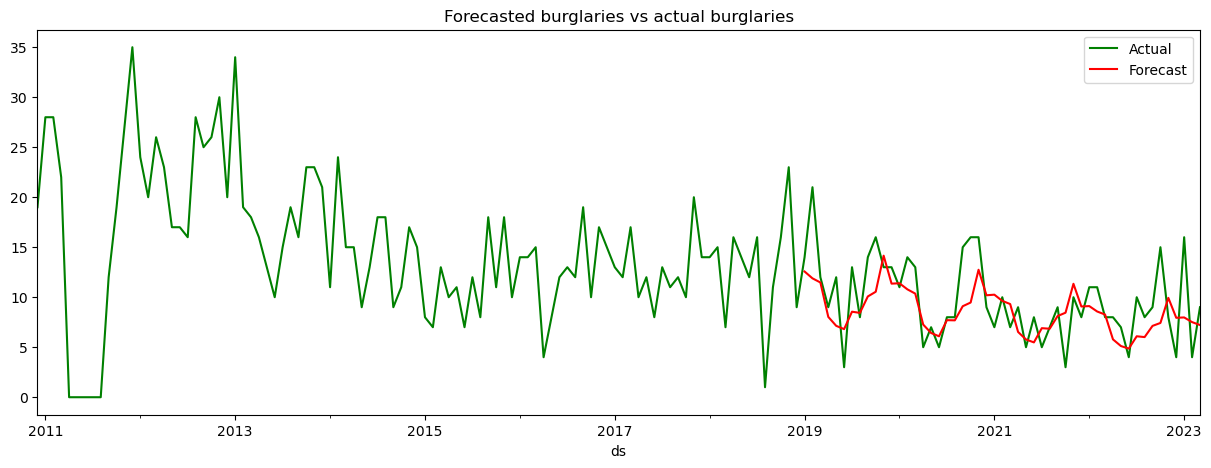

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:54 - cmdstanpy - INFO - Chain [1] start processing
11:05:54 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Golders Green
-0.7361934385790758


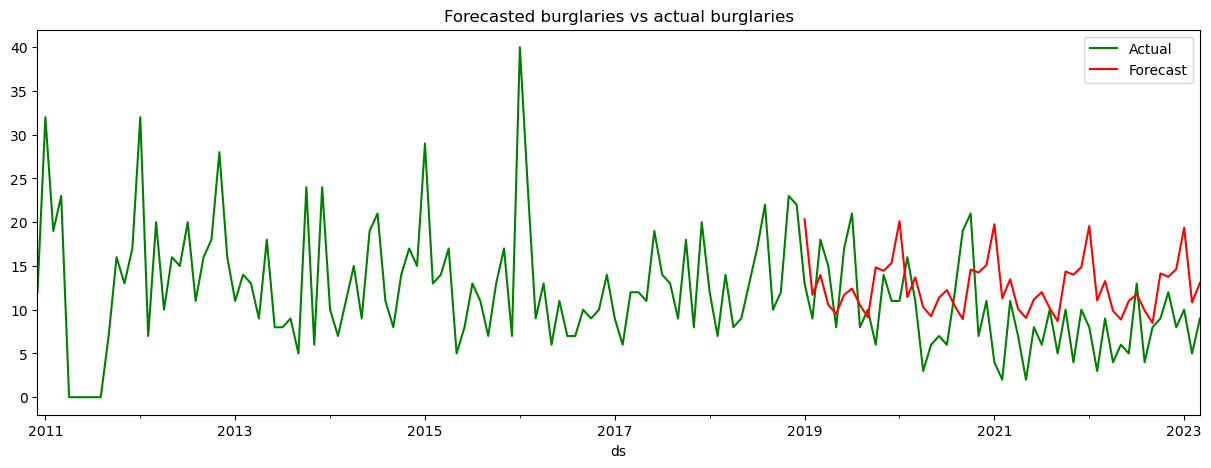

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:55 - cmdstanpy - INFO - Chain [1] start processing
11:05:55 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Hendon
-0.13564899187382395


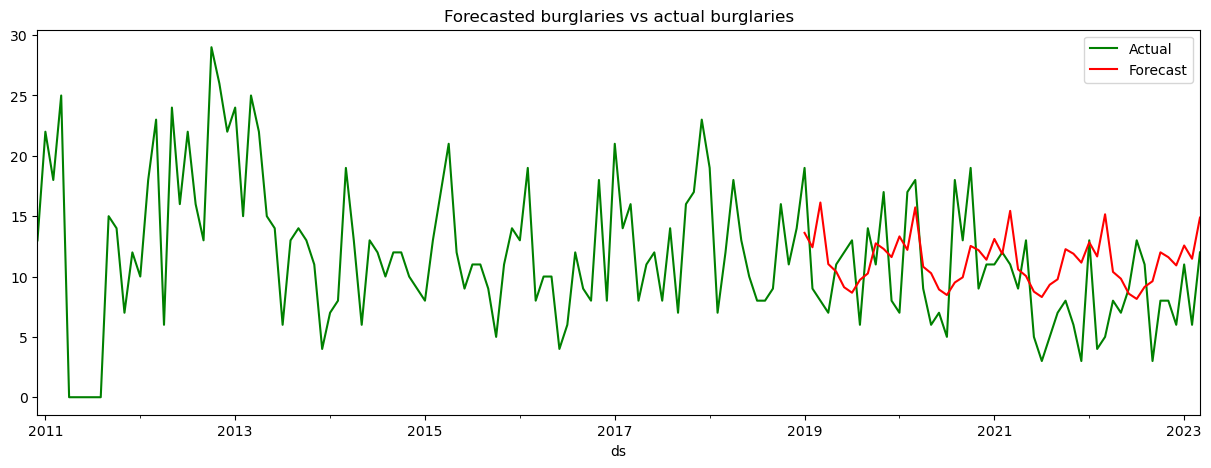

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:56 - cmdstanpy - INFO - Chain [1] start processing
11:05:56 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
High Barnet
-0.2530631898874627


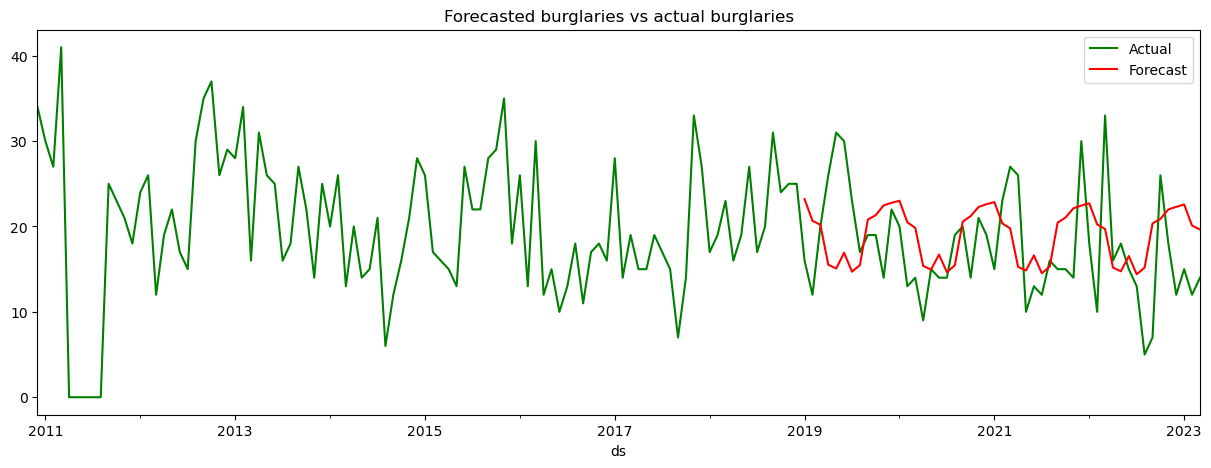

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:57 - cmdstanpy - INFO - Chain [1] start processing
11:05:58 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Mill Hill
0.0025706235587719117


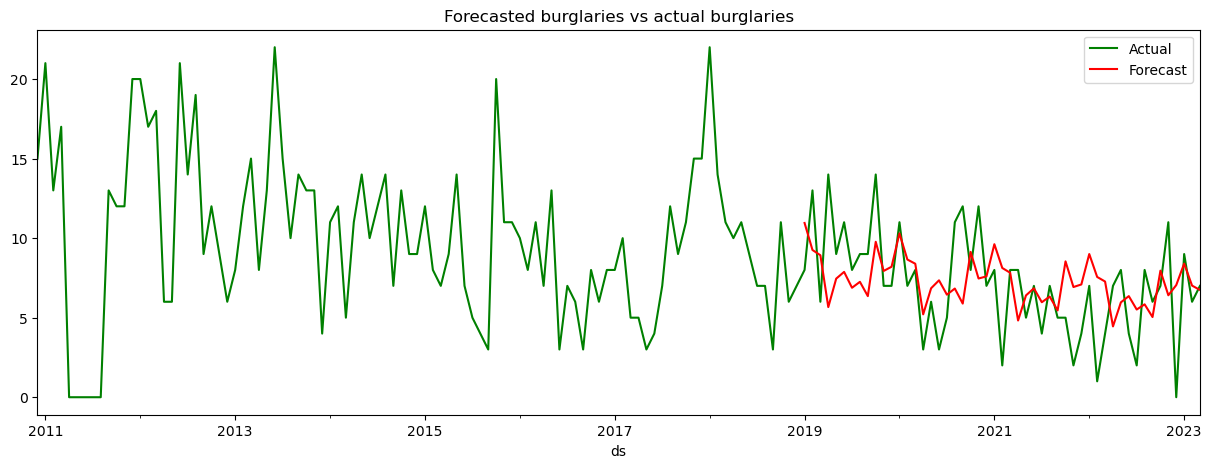

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:05:59 - cmdstanpy - INFO - Chain [1] start processing
11:05:59 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Underhill
-0.21702557707749714


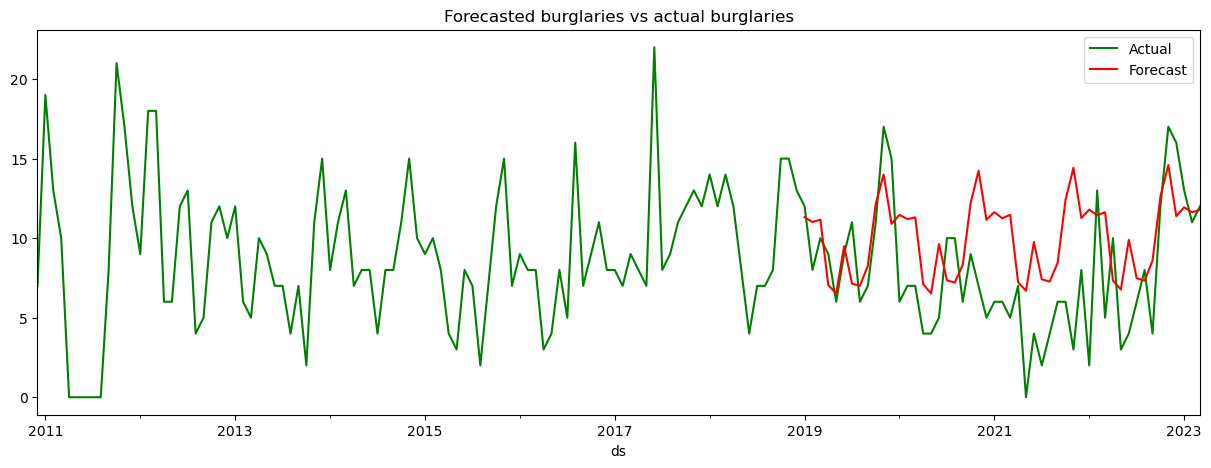

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:06:00 - cmdstanpy - INFO - Chain [1] start processing
11:06:00 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
West Finchley
-0.9478498682923395


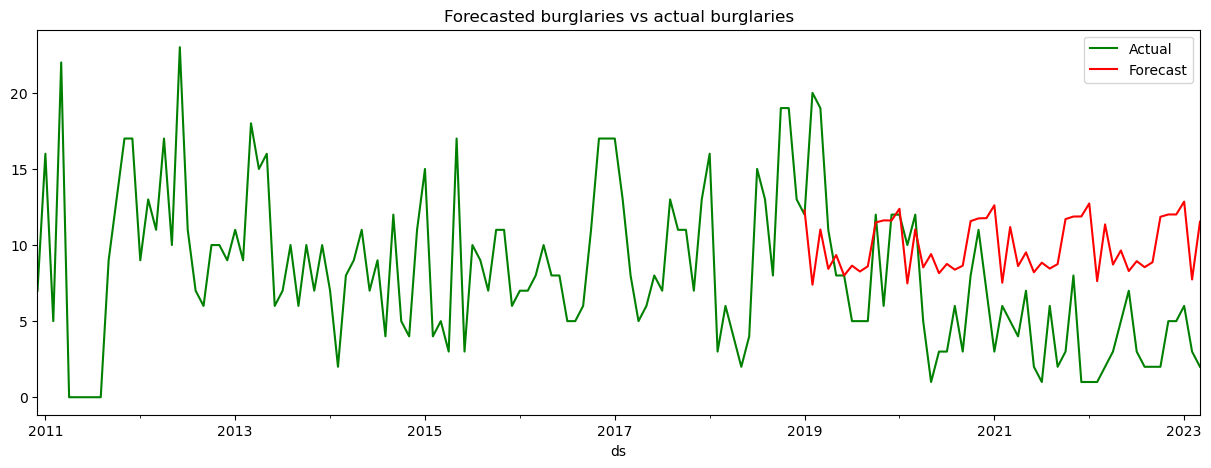

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:06:01 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
West Hendon
-0.6901792968008871


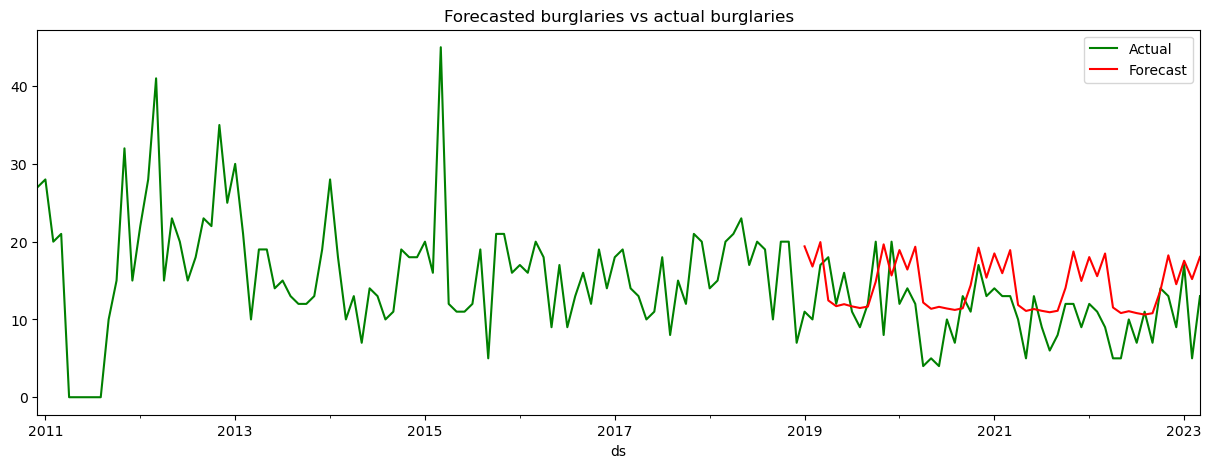

C:\Users\20203697\AppData\Local\Temp\ipykernel_11936\2661513880.py:23: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


11:06:02 - cmdstanpy - INFO - Chain [1] start processing
11:06:03 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Woodhouse
-0.00937414230149991


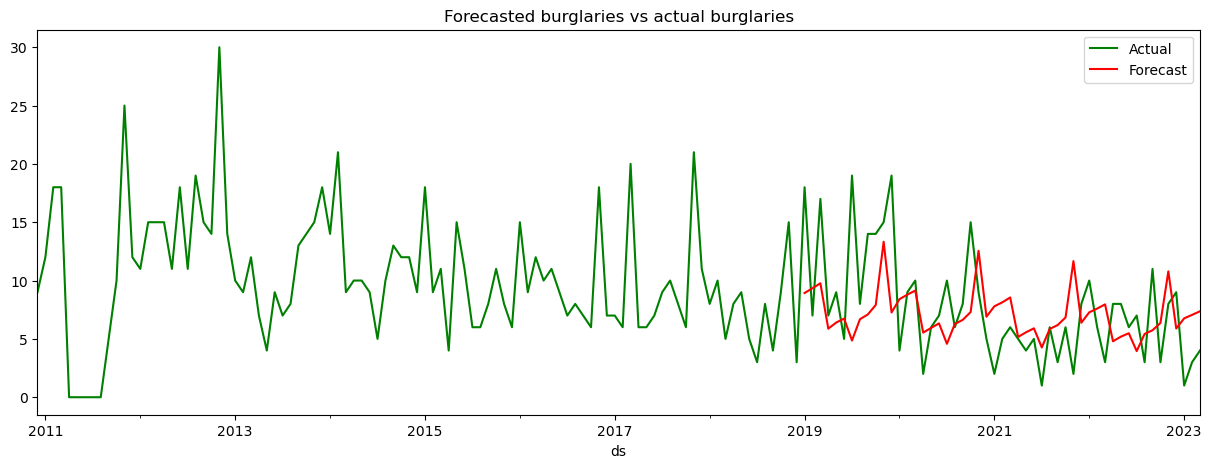

In [16]:
# Get holiday dataset
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Loop over wards
wards = ['Brunswick Park', 'Burnt Oak', 'Childs Hill', 'East Barnet',
       'East Finchley', 'Edgware', 'Finchley Church End', 'Garden Suburb',
       'Golders Green', 'Hendon', 'High Barnet', 'Mill Hill', 'Underhill',
       'West Finchley', 'West Hendon', 'Woodhouse']

for ward in wards: 
       # Select data of ward
       df_ward = df_per_ward[df_per_ward['Ward']==ward]
       df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population', 'Population per square kilometre', 'Hectares']]

       # Merge with all dates to have a consistent dataframe
       df_ward = pd.merge(dates, df_ward, how="left", on='Date')
       df_ward['ds'] = df_ward['Date']
       df_ward['y'] = df_ward['y'].fillna(0)
       df_ward = df_ward.fillna(df_ward.mean())
       df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
       train_ward = df_ward[df_ward['year']<(training_upto+1)]
       test_ward = df_ward[(df_ward['year']>training_upto)] 
       print((df_ward['Population'].isnull().sum()))
       print(df_ward.columns)
       best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday)
       best_model.add_regressor('Population per square kilometre')
       best_model.fit(train_ward)
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       print(future_dates)
       future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
       forecast = best_model.predict(future_dates)
       print(ward)
       print(r2_score(test_ward[['y']], forecast['yhat'][-forecast_upto:]))
       f, ax = plt.subplots(figsize=(14,5))
       f.set_figheight(5)
       f.set_figwidth(15)
       
       df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
       forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
       plt.title('Forecasted burglaries vs actual burglaries')
       plt.show()
       

C:\Users\20203697\AppData\Local\Temp\ipykernel_19804\1192985286.py:13: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



0
Index(['Date', 'ds', 'year', 'y', 'Population',
       'Population per square kilometre', 'Hectares'],
      dtype='object')


22:33:38 - cmdstanpy - INFO - Chain [1] start processing
22:33:39 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Brunswick Park
-0.10701320038663331


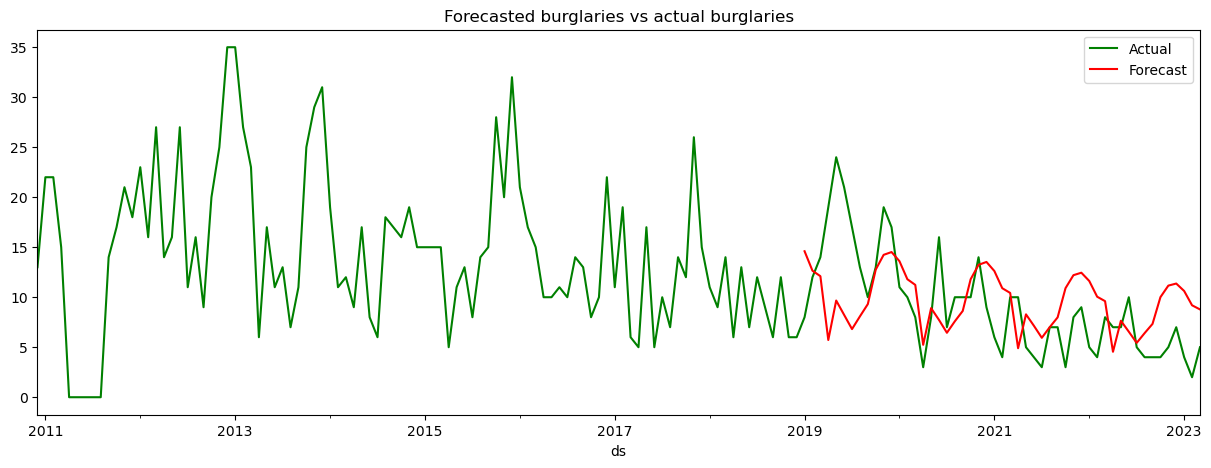

In [7]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

ward = 'Brunswick Park'
df_ward = df_per_ward[df_per_ward['Ward']==ward]
df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population', 'Population per square kilometre', 'Hectares']]
df_ward = pd.merge(dates, df_ward, how="left", on='Date')
df_ward['ds'] = df_ward['Date']
df_ward['y'] = df_ward['y'].fillna(0)
df_ward = df_ward.fillna(df_ward.mean())
df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
train_ward = df_ward[df_ward['year']<(training_upto+1)]
test_ward = df_ward[(df_ward['year']>training_upto)] 
print((df_ward['Population'].isnull().sum()))
print(df_ward.columns)
best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday)
best_model.add_regressor('Population per square kilometre')
best_model.fit(train_ward)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
print(future_dates)
future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
forecast = best_model.predict(future_dates)
print(ward)
print(r2_score(test_ward[['y']], forecast['yhat'][-forecast_upto:]))
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries')
plt.show()
